In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for data', fontsize=15)
    plt.show()


In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: ../input/dataset_fixed.csv

In [5]:
data = pd.read_csv("dataset_fixed.csv", parse_dates=["timestamp"])

Let's take a quick look at what the data looks like:

In [6]:
data.head(5)

,id,timestamp,co2,temp,humidity,light,node
0,4678229,1533243314,2.944000e+03,30.5,61.0,89.0,9
1,6642641,1533365453,2.779064e+09,27.3,0.0,667.0,73
2,8267680,1533199750,3.470000e+02,-100.0,63.8,24.0,0
3,8267681,1533199751,2.870000e+02,27.6,63.8,25.0,0
4,8267682,1533199752,2.960000e+02,27.6,63.8,24.0,0


Distribution graphs (histogram/bar graph) of sampled columns:

# Feature Engineering

#### Throw record_id away

In [7]:
data = data.drop("id", axis=1)

#### Change co2 to numeric

In [8]:
data[["co2"]] = pd.to_numeric(data["co2"], errors="coerce")

#### Change temp to numeric

In [9]:
data[["temp"]] = pd.to_numeric(data["temp"], errors="coerce")

#### Change humidity to numeric

In [10]:
data[["humidity"]] = pd.to_numeric(data["humidity"], errors="coerce")

#### Change light intensity to numeric

In [11]:
data[["light"]] = pd.to_numeric(data["light"], errors="coerce")

#### Remove outliers

In [12]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [13]:
data = remove_outlier(data, "co2")

In [14]:
data = remove_outlier(data, "temp")

In [15]:
data = remove_outlier(data, "humidity")

In [16]:
data = remove_outlier(data, "light")

In [17]:
data = remove_outlier(data, "node")

### Feature Extracting

In [18]:
from datetime import datetime

In [19]:
def timestamp_to_hour(row):
    timestamp = row["timestamp"]
    date=datetime.fromtimestamp(int(timestamp))
    return int(date.strftime("%H"))

In [20]:
def timestamp_to_is_weekday(row):
    timestamp = row["timestamp"]
    date=datetime.fromtimestamp(int(timestamp))
    return int(date.weekday() < 5)

#### Add new feature "hour"

In [21]:
data["hour"] = data.apply(timestamp_to_hour, axis=1)

#### Add new feature "weekday"

In [22]:
data["weekday"] = data.apply(timestamp_to_is_weekday, axis=1)

#### Fill or Remove NaN

In [23]:
data.isna().sum()

timestamp    0
co2          0
temp         0
humidity     0
light        0
node         0
hour         0
weekday      0
dtype: int64

Karena sudah tidak ada nilai NaN dalam dataset ini (sudah terhapus ketika menghapus outlier), maka proses ini dapat diabaikan

## Data visualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a165a9b38>,
      dtype=object)

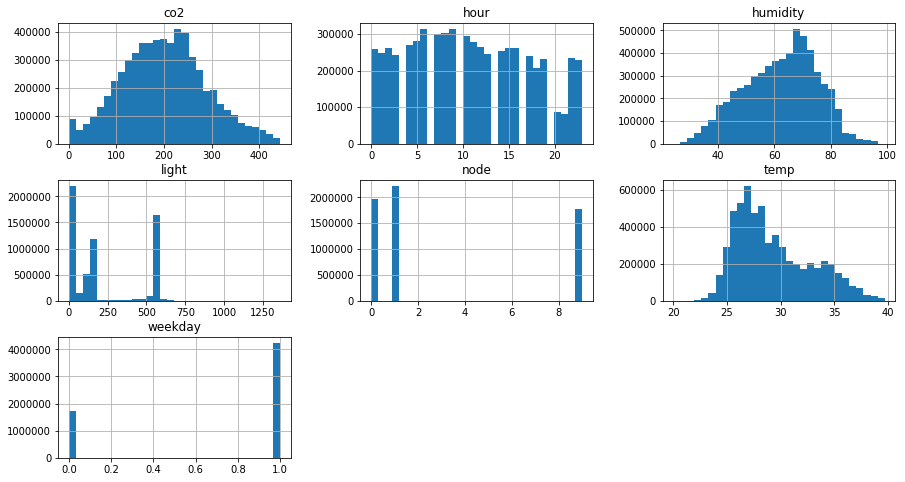

In [24]:
data.hist(bins=30, figsize=(15,8))

Correlation matrix:

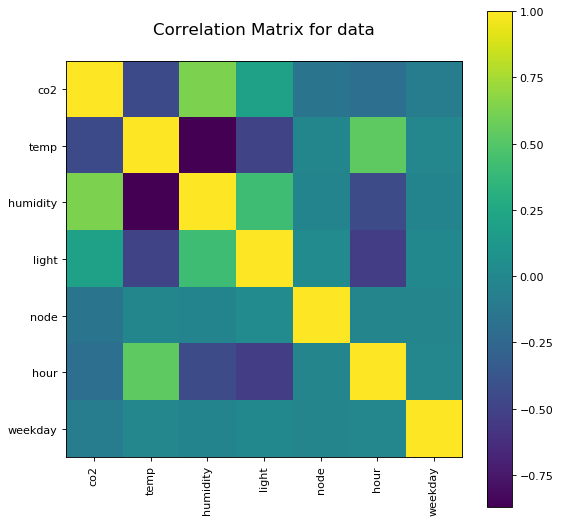

In [25]:
plotCorrelationMatrix(data, 8)

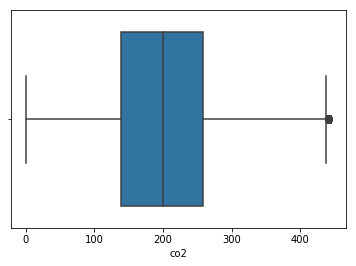

In [26]:
sns.boxplot(x="co2", data=data)

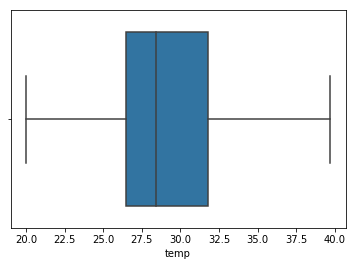

In [27]:
sns.boxplot(x="temp", data=data)

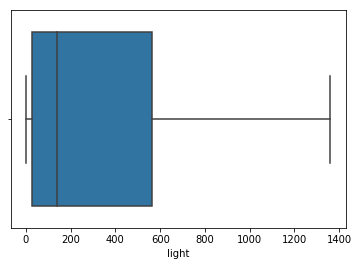

In [28]:
sns.boxplot(x="light", data=data)

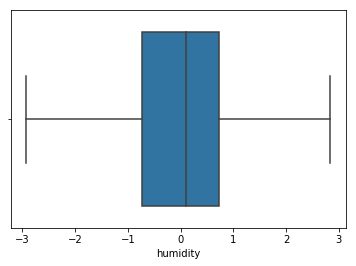

In [63]:
sns.boxplot(x="humidity", data=data)

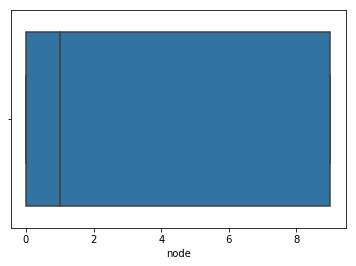

In [29]:
sns.boxplot(x="node", data=data)

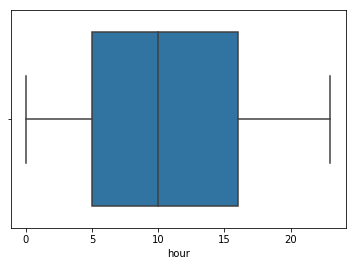

In [30]:
sns.boxplot(x="hour", data=data)

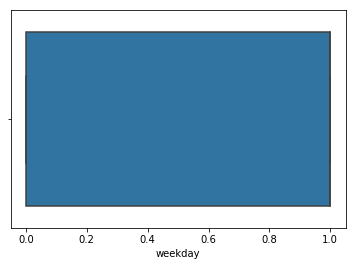

In [31]:
sns.boxplot(x="weekday", data=data)

# Get Dummies

In [32]:
dummies = pd.get_dummies(data["node"], prefix="node")
data = pd.concat([data.drop("node", axis=1), dummies], axis=1)

# Scaling

In [33]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#### Drop timestamp

In [34]:
data = data.drop("timestamp", axis=1)

#### Scale data

In [35]:
data.columns.values

array(['co2', 'temp', 'humidity', 'light', 'hour', 'weekday', 'node_0',
       'node_1', 'node_9'], dtype=object)

In [39]:
data_num = data.drop(["weekday", "node_0", "node_1", "node_9"], axis=1)
data_categ = data.loc[:, "weekday":"node_9"]

In [40]:
cols = data_num.columns.values
data_num = pd.DataFrame(data=sc.fit_transform(data_num), columns=cols)

In [41]:
data_num[["weekday", "node_0", "node_1", "node_9"]] = data_categ.reset_index().loc[:, "weekday":"node_9"]

In [42]:
data = data_num

# Split train and test data

In [43]:
data.shape

(5959493, 9)

In [44]:
Y = data.loc[:, "temp"].values
X = data.drop("temp", axis=1).values

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Machine Learning Methods

Metode-metode yang akan digunakan adalah:
* Linear Regression
* Ridge Regression
* Stochastic Gradient Descent
* Decision Tree Regression
* Random Forest Regression

In [59]:
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [55]:
lr = LinearRegression()
rid = Ridge()
sgd = SGDRegressor(tol=1e-6)
dt = DecisionTreeRegressor(max_depth=7)
rf = RandomForestRegressor(n_estimators=80, max_depth=7)

In [60]:
lr.fit(X_train, y_train)
rid.fit(X_train, y_train)
sgd.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=1e-06, verbose=0,
       warm_start=False)

In [56]:
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:
print("ACCURACY")
print("Linear Regression:", lr.score(X_test, y_test))
print("Ridge Regression:", rid.score(X_test, y_test))
print("SGD Regression:", sgd.score(X_test, y_test))
print("Decision Tree Regression:", dt.score(X_test, y_test))
print("Random Forest Regression:", rf.score(X_test, y_test))

ACCURACY
Linear Regression: 0.8099797931758064
Ridge Regression: 0.8099797921173176
SGD Regression: 0.8099221719935217
Decision Tree Regression: 0.9200920469582079
Random Forest Regression: 0.9213638676332488
